In [1]:
from src.models.vae import VAE
from src.trainer import CLEARVAETrainer, HierachicalVAETrainer
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [4]:
np.random.seed(101)
torch.manual_seed(101)

In [5]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

generator = StyledMNISTGenerator(
     mnist,
    {
        lambda x: corruptions.rgb_change(x, "red"): 0.15,
        lambda x: corruptions.rgb_change(x, "green"): 0.25,
        lambda x: corruptions.rgb_change(x, "blue"): 0.15,
        lambda x: corruptions.rgb_change(x, "yellow"): 0.15,
        lambda x: corruptions.rgb_change(x, "cyan"): 0.2,
        lambda x: corruptions.rgb_change(x, "magenta"): 0.1,
    },
)


dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:02<00:00, 21362.47item/s]


In [23]:
Z_DIM = 8
TEMP = 0.3
ALPHA = 1e2
LABEL_FLIPPING = True

clear_vae = VAE(total_z_dim=Z_DIM, in_channel=3).to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(clear_vae.parameters(), lr=1e-3)
clear_trainer = CLEARVAETrainer(
    clear_vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/4, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [24]:
clear_trainer.fit(31, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 183.27it/s]


val_recontr_loss=325.474, val_kl_c=8.257, val_kl_s=9.511, val_c_loss=0.568, val_s_loss=0.109
gMIG: 0.348; mse: 325.474


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 189.62it/s]


val_recontr_loss=86.931, val_kl_c=9.803, val_kl_s=10.530, val_c_loss=0.466, val_s_loss=0.109
gMIG: 0.438; mse: 86.931


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 183.47it/s]


val_recontr_loss=50.906, val_kl_c=9.835, val_kl_s=10.302, val_c_loss=0.451, val_s_loss=0.109
gMIG: 0.437; mse: 50.906


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 185.90it/s]


val_recontr_loss=39.320, val_kl_c=10.071, val_kl_s=10.184, val_c_loss=0.440, val_s_loss=0.109
gMIG: 0.449; mse: 39.32


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 166.43it/s]


val_recontr_loss=34.172, val_kl_c=9.941, val_kl_s=10.248, val_c_loss=0.438, val_s_loss=0.108
gMIG: 0.443; mse: 34.172


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 180.14it/s]


val_recontr_loss=32.030, val_kl_c=10.022, val_kl_s=10.062, val_c_loss=0.435, val_s_loss=0.108
gMIG: 0.449; mse: 32.03


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 190.58it/s]


val_recontr_loss=30.272, val_kl_c=9.922, val_kl_s=9.936, val_c_loss=0.433, val_s_loss=0.109
gMIG: 0.441; mse: 30.272


In [ ]:
Z_DIM = 16

ml_vae = VAE(total_z_dim=Z_DIM, group_mode="MLVAE").to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(ml_vae.parameters(), lr=1e-3)
ml_trainer = HierachicalVAETrainer(
    ml_vae,
    optimizer,
    hyperparameter={"beta": 1 / 8, "loc": 0, "scale": 1},
    verbose_period=5,
    device=device,
)

In [ ]:
ml_trainer.fit(31, train_loader, valid_loader, with_evidence_acc=True)

In [41]:
Z_DIM = 16

gvae = VAE(total_z_dim=Z_DIM, group_mode="GVAE").to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(gvae.parameters(), lr=1e-3)
g_trainer = HierachicalVAETrainer(
    gvae,
    optimizer,
    hyperparameter={"beta": 1 / 8, "loc": 0, "scale": 1},
    verbose_period=5,
    device=device,
)

In [ ]:
g_trainer.fit(31, train_loader, valid_loader, with_evidence_acc=True)

In [11]:
from expr.visual_utils import feature_swapping_plot, interpolation_plot

### clear-vae

In [25]:
# torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
clear_vae.eval()
X_hat, latent_params, z = clear_vae(X.clone(), explicit=True)


In [26]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

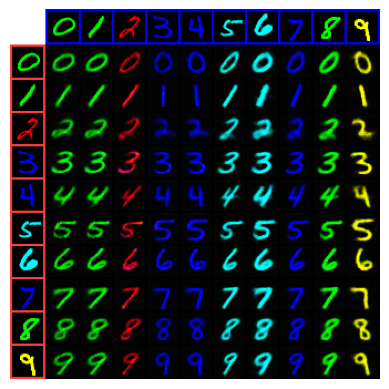

In [27]:
# illustration using all c
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], clear_vae)


In [28]:
# illustration using all s
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape

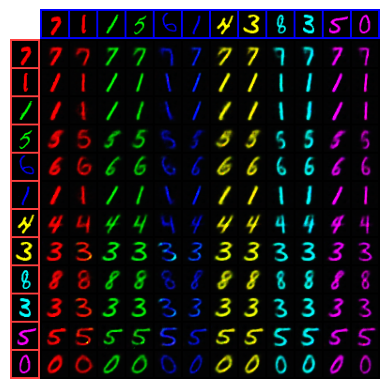

In [29]:
feature_swapping_plot(z_c, z_s, X[img_idx], clear_vae)

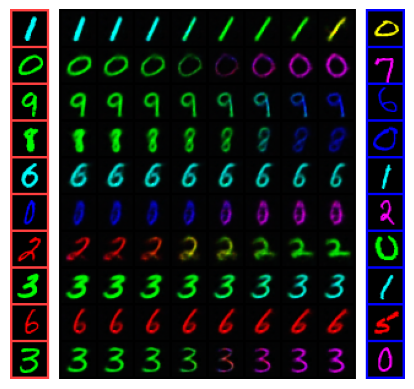

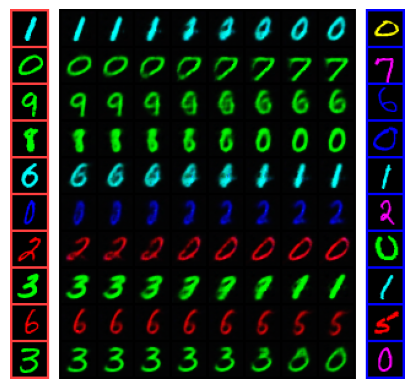

In [30]:
# torch.manual_seed(1111)
# np.random.seed(1111)
interpolation_plot(X, z, clear_vae, int(Z_DIM / 2), inter_steps=8)

### ml-vae

In [19]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
ml_vae.eval()
X_hat_acc, latent_params_acc, z_acc = ml_vae(X.clone(), explicit=True)
X_hat_nacc, latent_params_nacc, z_nacc = ml_vae(X.clone(), c, explicit=True)

In [20]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

In [ ]:
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], ml_vae)

In [ ]:
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], ml_vae)

In [ ]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z_acc, ml_vae, int(Z_DIM / 2), inter_steps=8)

### gvae

In [24]:
torch.manual_seed(111)
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
gvae.eval()
X_hat_acc, latent_params_acc, z_acc = gvae(X.clone(), explicit=True)
X_hat_nacc, latent_params_nacc, z_nacc = gvae(X.clone(), c, explicit=True)

In [25]:
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]

In [ ]:
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], gvae)

In [ ]:
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())
with torch.no_grad():
    z_c, z_s = z_acc[img_idx, :int(Z_DIM / 2)], z_acc[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape
feature_swapping_plot(z_c, z_s, X[img_idx], gvae)

In [ ]:
torch.manual_seed(1111)
np.random.seed(1111)
interpolation_plot(X, z_acc, gvae, int(Z_DIM / 2), inter_steps=8)